In [1]:
import pandas as pd
import numpy as np
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Артем
[nltk_data]     Буданцев\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Артем
[nltk_data]     Буданцев\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
comments = pd.concat((pd.read_csv('comments_0-2000.csv'), pd.read_csv('comments_2000-7000.csv')), axis=0).dropna(subset=['text'])
comments.head()

,id,post_id,from_id,date,likes,reply_to_comment,text
1,5188229,5187887,801731288,1685085644,0,NaN,ну вот и очередной теракт Украина провела. ясм...
2,5188483,5187887,690352028,1685093934,0,NaN,Этой ночью наши войска хорошенько прошлись по ...
4,5188857,5188835,804081222,1685103137,0,NaN,Сборище воров и преступников
9,5188790,5188775,709590604,1685101388,0,NaN,К ней надо ставить охрану
10,5188703,5188688,153563384,1685098953,1,NaN,"Солидный инстумент,и уже обкатан на передке СВ..."


In [11]:
comments_texts = [text.replace('\\n', '\n') for text in comments.text]

In [12]:
from nltk.tokenize import word_tokenize
comments_tokens = [[tok for tok in word_tokenize(text.lower(), language='russian')] for text in comments_texts]

In [13]:
import pymorphy2
from tqdm import tqdm
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

parser = pymorphy2.MorphAnalyzer()
normalized_comments_tokens = list()
for comment in tqdm(comments_tokens):
    new_tokens = [normal_form for tok in comment if (normal_form := parser.parse(tok)[0].normal_form) not in russian_stopwords]
    normalized_comments_tokens.append(new_tokens)

normalized_comments_tokens[:10]

100%|███████████████████████████████████████████████████████████████████████████| 69468/69468 [03:21<00:00, 344.80it/s]


[['очередной',
  'теракт',
  'украина',
  'провести',
  '.',
  'ясмотреть',
  'мочь',
  'проживать'],
 ['ночью',
  'наш',
  'войско',
  'хорошенько',
  'пройтись',
  'позиция',
  'всу',
  'геранька',
  'калибр'],
 ['сборище', 'вор', 'преступник'],
 ['ставить', 'охрана'],
 ['солидный',
  'инстумент',
  ',',
  'обкатать',
  'передок',
  'сво',
  '.',
  'достойный',
  '``',
  'внук',
  "''",
  'свд',
  '.'],
 ['🇷🇺🇷🇺🇷🇺приятный',
  'видеть',
  ',',
  'легендарный',
  'образец',
  'русский',
  'оружие',
  'иметь',
  'продолжение',
  'апгрейта',
  '!',
  '!',
  '!',
  '👍'],
 ['начало',
  'это',
  'год',
  'президент',
  'россия',
  'владимир',
  'путин',
  'посетить',
  'концерн',
  '«',
  'калашников',
  '»',
  ',',
  'изготовитель',
  '«',
  'свч',
  '»',
  ',',
  'произвести',
  'несколько',
  'выстрел',
  '.',
  'снайперский',
  'винтовка',
  'чукавино',
  'получить',
  'широкий',
  'известность',
  'появление',
  'пресса',
  'фотография',
  ',',
  'который',
  'запечатлеть',
  'стрелять'

In [41]:
def prepare_text(text, analyzer=None):
    tokens = [tok for tok in word_tokenize(text.replace('\\n', '\n').lower(), language='russian')]
    parser = analyzer or pymorphy2.MorphAnalyzer()
    new_tokens = [normal_form for tok in tokens if (normal_form := parser.parse(tok)[0].normal_form) not in russian_stopwords]
    return new_tokens

In [14]:
import gensim
tagged_normalized_comments_tokens = [gensim.models.doc2vec.TaggedDocument(comment, [i]) for i, comment in enumerate(normalized_comments_tokens)]
tagged_normalized_comments_tokens[:10]

D:\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


[TaggedDocument(words=['очередной', 'теракт', 'украина', 'провести', '.', 'ясмотреть', 'мочь', 'проживать'], tags=[0]),
 TaggedDocument(words=['ночью', 'наш', 'войско', 'хорошенько', 'пройтись', 'позиция', 'всу', 'геранька', 'калибр'], tags=[1]),
 TaggedDocument(words=['сборище', 'вор', 'преступник'], tags=[2]),
 TaggedDocument(words=['ставить', 'охрана'], tags=[3]),
 TaggedDocument(words=['солидный', 'инстумент', ',', 'обкатать', 'передок', 'сво', '.', 'достойный', '``', 'внук', "''", 'свд', '.'], tags=[4]),
 TaggedDocument(words=['🇷🇺🇷🇺🇷🇺приятный', 'видеть', ',', 'легендарный', 'образец', 'русский', 'оружие', 'иметь', 'продолжение', 'апгрейта', '!', '!', '!', '👍'], tags=[5]),
 TaggedDocument(words=['начало', 'это', 'год', 'президент', 'россия', 'владимир', 'путин', 'посетить', 'концерн', '«', 'калашников', '»', ',', 'изготовитель', '«', 'свч', '»', ',', 'произвести', 'несколько', 'выстрел', '.', 'снайперский', 'винтовка', 'чукавино', 'получить', 'широкий', 'известность', 'появление', 

In [99]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=128, min_count=2, epochs=100)
model.build_vocab(tagged_normalized_comments_tokens)
model.train(tagged_normalized_comments_tokens, total_examples=model.corpus_count, epochs=model.epochs)

In [100]:
comments_vectors = np.array([model.infer_vector(comment.words) for comment in tagged_normalized_comments_tokens])
comments_vectors[:10]

array([[-0.23510708,  0.7082023 ,  0.25866425, ...,  0.17366199,
         0.4086131 , -0.4292447 ],
       [-0.24349415, -0.03012537, -0.43125546, ...,  0.31880823,
        -0.01186133,  0.6642454 ],
       [ 0.01876086, -0.07407078, -0.04717764, ..., -0.1350836 ,
        -0.05234072,  0.229971  ],
       ...,
       [ 0.12542436,  0.07326221, -0.00707446, ...,  0.18934955,
         0.03966351, -0.16092242],
       [-0.02386817, -0.16174716, -0.08287842, ...,  0.00554032,
        -0.1534871 ,  0.05840402],
       [-0.39700755, -0.01129232,  0.22148092, ...,  0.2576661 ,
         0.14808716,  0.22396268]], dtype=float32)

In [101]:
from umap import UMAP
umap = UMAP(metric='cosine')
proj_comments = umap.fit_transform(comments_vectors)

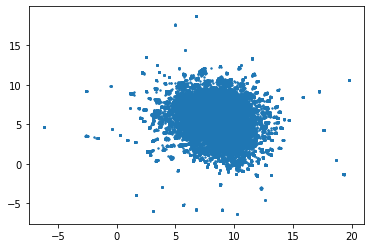

In [102]:
from matplotlib import pyplot as plt

plt.scatter(proj_comments[:, 0], proj_comments[:, 1], s=2)

In [93]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import normalize
clust_alg = KMeans(n_clusters=10)
# clust_alg = DBSCAN(eps=0.0009, metric='cosine')

clusters = clust_alg.fit_predict(normalize(comments_vectors))
print(max(clusters))

24


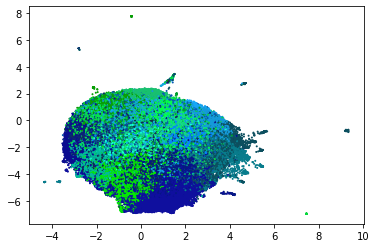

In [94]:
import random
random_colors = [f'#{hex(random.randint(0, 1677215))[2:].rjust(6, "0")}' for _ in range(max(clusters) + 1)]
plt.scatter(proj_comments[:, 0], proj_comments[:, 1], s=1, c=[random_colors[i] for i in clusters])
plt.show()

In [95]:
for clust_id in clusters:
    comments.iloc[[i for i in range(len(clusters)) if clusters[i] == clust_id]].to_csv(f'comments_clust{clust_id}.csv')

KeyboardInterrupt: 

In [149]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(comments_vectors, comments.likes.to_numpy(), test_size=0.1)

reg = MLPRegressor(learning_rate_init=0.001, hidden_layer_sizes=(256,))
reg.fit(X_train, y_train)

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(256,))

In [152]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.clip(reg.predict(X_test), 0, 100), y_test) ** 0.5 / y_test.std(), mean_squared_error(np.clip(reg.predict(X_train), 0, 100), y_train) ** 0.5 / y_train.std()

(1.0322548714696853, 0.8096694812558479)

In [105]:
comment = comments.iloc[[157]].text.values[0]
print(comment)
comment_vec = model.infer_vector(prepare_text(comment))
indices = [x[0] for x in sorted(enumerate(comments_vectors), key=lambda x: (x[1] @ comment_vec) / np.linalg.norm(x[1]) / np.linalg.norm(comment_vec))[-10:]]
comments.iloc[indices].text

Медведева слушать себя не уважать , он с единственной фразой потерял уважение , денег нет , но вы держитесь , этого размазню наверно из-за фамилии взяли в правительство , сейчас он как посмешище для народа


7766     кто первый уйдет то и сильнее второй слабак и ...
28095                                          да и пофиг.
2999     Когда фраза бомбить Воронеж трансформировалась...
12886               Монархов много , они не единственные .
53011    ДЕНИС    Проценко  какой  молодец!  Врач  от  ...
46614                     Наркошу слушать себя не уважать.
28955    После этой фразы в польском поезде начался сущ...
27465    И где же-эта древняя культура-совсем достоинст...
43881    Кто ж Медведеву статьи пишет? Сам то он два сл...
175      Медведева слушать себя не уважать , он с единс...
Name: text, dtype: object

In [56]:
comments.iloc[[65863]]

,id,post_id,from_id,date,likes,reply_to_comment,text
50672,4992806,4991802,285646277,1676817168,0,NaN,"Всё видят и знают, но ничего не меняется"


In [154]:
list(zip(np.clip(reg.predict(X_test), 0, 100), y_test))[:40]

[(0.0, 18),
 (10.250546451856628, 25),
 (9.311272418296808, 0),
 (5.988825163110093, 2),
 (7.2888702673595525, 1),
 (3.071940927787189, 0),
 (4.200497896339981, 0),
 (0.0, 0),
 (0.043335341564707086, 0),
 (0.0, 2),
 (1.2717502087368509, 1),
 (5.76739565590891, 4),
 (0.7644048168937303, 4),
 (5.344389602349629, 0),
 (13.899450218109767, 3),
 (3.355338302728878, 0),
 (0.9374028044570797, 0),
 (9.000618427650455, 7),
 (1.731131706932775, 0),
 (5.973328275487821, 1),
 (0.0, 4),
 (0.0, 0),
 (15.617016473428961, 0),
 (0.3550703016029595, 0),
 (5.571986187021993, 1),
 (3.5077169987059413, 0),
 (3.1747152617143666, 0),
 (0.0, 0),
 (23.793264332370207, 0),
 (0.0, 0),
 (3.140684418895205, 4),
 (8.55508486415605, 4),
 (4.510481228451864, 8),
 (0.0, 7),
 (0.0, 0),
 (0.0, 0),
 (10.40114741394062, 0),
 (2.450924519162858, 2),
 (1.2222129434944442, 10),
 (7.422409682496681, 1)]